In [105]:
import numpy as np
import igl
import meshplot as mp
from scipy.spatial.transform import Rotation
import ipywidgets as iw
import time
import scipy.sparse as sp
import triangle as tr
import matplotlib.pyplot as plt

In [135]:
v, f = igl.read_triangle_mesh('data/woody-hi.off')
cage = np.load('data/woody-hi.cage-1.npy')
v -= v.min(axis=0)
v /= v.max()

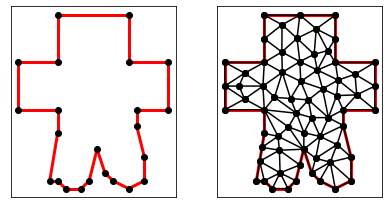

In [136]:
cage_connect = (np.vstack((np.arange(cage.shape[0]), np.arange(cage.shape[0])+1))).T
cage_connect[-1,-1] = 0

cage_dict = dict(vertices=cage[:,:2], segments=cage_connect)
cage_tri = tr.triangulate(cage_dict, 'pqa0.01')

tr.compare(plt, cage_dict, cage_tri)
plt.show()

cage_v = cage_tri['vertices']
cage_f = cage_tri['triangles']
cage_markers = cage_tri['vertex_markers']

cage_v = np.hstack((cage_v, np.zeros((cage_v.shape[0],1))))

In [137]:
num_cage_boundary_v = cage.shape[0]

In [138]:
Lw = igl.cotmatrix(cage_v, cage_f)
M = igl.massmatrix(cage_v, cage_f, igl.MASSMATRIX_TYPE_VORONOI)
Minv = sp.diags(1 / M.diagonal())

In [139]:
# A = Minv * Lw
# Aff = A[np.argwhere(cage_markers!=1)[:,0],:]
# Aff = Aff[:,np.argwhere(cage_markers!=1)[:,0]]
# Afc = A[np.argwhere(cage_markers!=1)[:,0],:]
# Afc = Afc[:,np.argwhere(cage_markers==1)[:,0]]
# xc = np.eye(np.sum(cage_markers))
# rhs = -Afc * xc
# xf = sp.linalg.spsolve(Aff, rhs)
# x = np.zeros((cage_v.shape[0], np.sum(cage_markers)))
# x[np.argwhere(cage_markers==1)[:,0],:] = xc
# x[np.argwhere(cage_markers!=1)[:,0],:] = xf

In [140]:
# A = Minv * Lw
# Aff = A[num_cage_boundary_v:,:]
# Aff = Aff[:,num_cage_boundary_v:]
# Afc = A[num_cage_boundary_v:,:]
# Afc = Afc[:,:num_cage_boundary_v]
# xc = np.eye(num_cage_boundary_v)
# rhs = -Afc * xc
# xf = sp.linalg.spsolve(Aff, rhs)
# x = np.vstack((xc, xf))

In [141]:
augmented_boundary = igl.boundary_loop(cage_f)

In [142]:
A = Minv * Lw
Aff = A[np.argwhere(cage_markers!=1)[:,0],:]
Aff = Aff[:,np.argwhere(cage_markers!=1)[:,0]]
Afc = A[np.argwhere(cage_markers!=1)[:,0],:]
Afc = Afc[:,np.argwhere(cage_markers==1)[:,0]]
xc = np.zeros((np.sum(cage_markers), num_cage_boundary_v))
xc[:num_cage_boundary_v,:] = np.eye(num_cage_boundary_v)

augmented_boundary_v = np.argwhere(cage_markers==1)[num_cage_boundary_v:,0]
for i in range(augmented_boundary_v.size):
    curr_v = augmented_boundary_v[i]
    j = np.argwhere(augmented_boundary==curr_v)[0]
    
    k1 = j
    while True:
        k1 = (k1-1) if k1-1>=0 else augmented_boundary.size-1
        if augmented_boundary[k1] < num_cage_boundary_v:
            break
    k2 = j
    while True:
        k2 = (k2+1)%augmented_boundary.size
        if augmented_boundary[k2] < num_cage_boundary_v:
            break
    len_seg = np.linalg.norm(cage_v[augmented_boundary[k1]] - cage_v[augmented_boundary[k2]])
    len_k1 = np.linalg.norm(cage_v[augmented_boundary[k1]] - cage_v[curr_v])
    xc[i+num_cage_boundary_v,augmented_boundary[k2]] = len_k1 / len_seg
    xc[i+num_cage_boundary_v,augmented_boundary[k1]] = 1 - len_k1/len_seg      

rhs = -Afc * xc
xf = sp.linalg.spsolve(Aff, rhs)
x = np.zeros((cage_v.shape[0], num_cage_boundary_v))
x[:num_cage_boundary_v,:] = xc[:num_cage_boundary_v,:]
x[augmented_boundary_v,:] = xc[num_cage_boundary_v:,:]
x[np.argwhere(cage_markers!=1)[:,0],:] = xf

In [145]:
p = mp.plot(cage_v, cage_f, c=np.random.rand(*cage_f.shape))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4249999…

In [150]:
cage_v = x @ cage_v[:num_cage_boundary_v]
p.update_object(oid=0, vertices=cage_v)

In [3]:
p = mp.plot(v, f)#, shading={"wireframe":True})
p.add_points(cage, shading={"point_color":"green", "point_size":0.1})
p.add_lines(cage, np.vstack((cage[1:],cage[0])))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4306930…

1

In [12]:
cage_oid = p.add_mesh(cage_v, cage_f, shading={"wireframe":True})
p.update_object(oid=cage_oid, colors=x[:,3])

In [13]:
def within_triangle(p, v, f):
    for i in range(f.shape[0]):
        v0 = v[f[i,0]]
        v1 = v[f[i,1]]
        v2 = v[f[i,2]]
        A = np.vstack((v1-v0, v2-v0)).T
        b = (p-v0)
        sol = np.linalg.lstsq(A, b, rcond=None)[0]
        if (sol[0] >= 0 and sol[1] >= 0 and sol[0]+sol[1]<=1):
            return i

In [14]:
def barycentric_coord(p, v, f, i):
    v0 = v[f[i,0]]
    v1 = v[f[i,1]]
    v2 = v[f[i,2]]
    A = np.vstack((v0,v1,v2)).T
    A = np.vstack((A, np.ones((1,3))))
    b = np.hstack((p, np.array([1,])))
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w

In [15]:
hc = np.zeros((v.shape[0], np.sum(cage_markers)))
for i in range(v.shape[0]):
    cage_tri_ind = within_triangle(v[i], cage_v, cage_f)
    w = barycentric_coord(v[i], cage_v, cage_f, cage_tri_ind)
    hc[i,:] = w[0]*x[cage_f[cage_tri_ind,0], :] \
            + w[1]*x[cage_f[cage_tri_ind,1], :] \
            + w[2]*x[cage_f[cage_tri_ind,2], :]

In [16]:
test = hc @ cage_v[np.argwhere(cage_markers==1)[:,0],:]
p.update_object(oid=0, vertices=test)

In [17]:
cage_v[0,1] -= 0.09
p.update_object(oid=cage_oid, vertices=cage_v)

In [18]:
cage_v[1,1] -= 0.09
p.update_object(oid=cage_oid, vertices=cage_v)

In [19]:
cage_v[2,1] -= 0.09
p.update_object(oid=cage_oid, vertices=cage_v)

In [20]:
test = hc @ cage_v[np.argwhere(cage_markers==1)[:,0],:]
p.update_object(oid=0, vertices=test)

In [21]:
p.remove_object(1)
p.add_points(cage_v[:num_cage_boundary_v], shading={"point_color":"green", "point_size":0.1})

4